In [1]:
using LinearAlgebra
using StaticArrays
using SparseArrays

In [548]:
function deleterepeatedrows(original)
    sorted = sort(original, dims=2) # sort in rows
    unique = Tuple[] # unique edges
    indxes = Int64[] # unique indices for original edges
    for i in axes(sorted,1)
        test = tuple(sorted[i,:]...)
        if test ∉ unique
            push!(unique, test)
        end
    
        indx = findfirst(==(test), unique)
        if indx ≠ nothing
            push!(indxes, indx)
        end
    end
    
    return indxes
end

function get_edges(elems2nodes)
    nelems = size(elems2nodes, 1)
    
    # extracts sets of edges
    edges1=elems2nodes[:,[2,3]]
    edges2=elems2nodes[:,[3,1]]
    edges3=elems2nodes[:,[1,2]]

    # as sets of their nodes (vertices)
    vertices=zeros(Int64,nelems*3,2)
    vertices[1:3:end,:].=edges1
    vertices[2:3:end,:].=edges2
    vertices[3:3:end,:].=edges3
    
    # repeated sets of nodes (joint edges) are eliminated 
    indices = deleterepeatedrows(vertices)
    elems2edges = copy(transpose(reshape(indices, 3, :)))
    edges2nodes = unique(indices)#vertices[unique(indices),:]
    return elems2edges, edges2nodes
end

get_edges (generic function with 1 method)

In [3]:
function affine_transformations(nodes2coord,elems2nodes)
    # initialize
    nelems = size(elems2nodes,1);
    B_K    = zeros(2,2,nelems);

    # points defining the triangles
    A = nodes2coord[elems2nodes[:,1],1:2];
    B = nodes2coord[elems2nodes[:,2],1:2];
    C = nodes2coord[elems2nodes[:,3],1:2];
    
    # vectors defining the triangle
    a = B - A;
    b = C - A;

    # the affine mapping F_K = B_K * x + b_K
    B_K[:,1,:].= a';
    B_K[:,2,:].= b';
    b_K        = A;

    # determinant
    B_K_det = @. a[:,1] * b[:,2] - a[:,2] * b[:,1];
    
    return B_K, b_K, B_K_det
end

affine_transformations (generic function with 1 method)

In [4]:
function signs_edges(elems2nodes)
    tmp = elems2nodes[:,[2,3,1]] .- elems2nodes[:,[3,1,2]]
    signs = tmp ./ abs.(tmp)
    return signs
end

signs_edges (generic function with 1 method)

In [5]:
function intquad()
    ip = [1/6 2/3; 2/3 1/6; 1/6 1/6]
    wg = [1/6,1/6,1/6]
    
    return ip, wg, 3
end

intquad (generic function with 1 method)

In [6]:
function basis_N0(p)
    # initialize val and cval tensor
    np  = size(p, 1)
    val = zeros(np, 2, 3)
    rot = zeros(np, 1, 3)

    # calculate basis function values
    val[:,:,1] = [-p[:,2]       p[:,1]      ]
    val[:,:,2] = [-p[:,2]       p[:,1] .- 1.]
    val[:,:,3] = [ 1. .- p[:,2] p[:,1]      ]

    # calculate basis function curl values
    rot .+= 2.0
    
    return val, rot, 3
end

basis_N0 (generic function with 1 method)

In [7]:
function basis_RT0(p)
    # initialize val and cval tensor
    np  = size(p, 1)
    val = zeros(np, 2, 3)
    div = zeros(np, 1, 3)

    # calculate basis function values
    val[:,:,1] = [p[:,1]       p[:,2]      ]
    val[:,:,2] = [p[:,1] .- 1. p[:,2]      ]
    val[:,:,3] = [p[:,1]       p[:,2] .- 1.]

    # calculate basis function divergence values
    div .+= 2.0
    
    return val, div, 3
end

basis_RT0 (generic function with 1 method)

In [8]:
function stiffness_matrix_RT0(elems, B_K_det, signs, dofs)
    dim    = size(elems,2) - 1      # the dimension of the problem
    nelems = size(elems,1)          # number of elements
    nedges = maximum(elems)         # number of edges
    ip, w, nip = intquad()          # integration points and weighs (order 2, dimension 2)
    B_K_invabsdet = [inv(abs(x)) for x in B_K_det]
    
    # reference basis function div values on integration points,
    # and number of basis functions
    _, div, nbasis = basis_RT0(ip)
    
    # calculate all local stiffness matrices simultaneously
    Se = zeros(nbasis,nbasis,nelems)
    for i=1:nip
        for m=1:nbasis
            for k=1:nbasis
                for l=1:nelems
                    Se[m,k,l] += w[i] * B_K_invabsdet[l] *
                                 signs[l,m] * div[i,1,m] *
                                 signs[l,k] * div[i,1,k]
                end
            end
        end
    end
    
    # assemble global stiffness matrix
    S = spzeros(nedges, nedges)
    for l=1:nelems
        for m=1:nbasis
            e1 = dofs[elems[l,m]]
            for k=1:nbasis
                e2 = dofs[elems[l,k]]
                S[e1,e2] += Se[m,k,l]
            end
        end
    end
    return S
end

stiffness_matrix_RT0 (generic function with 1 method)

In [9]:
function mass_matrix_RT0(elems, B_K, B_K_det, signs, dofs)
    dim    = size(elems,2) - 1;   # the dimension of the problem
    nelems = size(elems,1);       # number of elements
    nedges = maximum(elems)       # number of edges
    ip, w, nip = intquad()        # integration points and weighs (order 2, dimension 2)
    B_K_invabsdet = [inv(abs(x)) for x in B_K_det]

    # reference basis function curl values on integration points,
    # and number of basis functions
    val, _, nbasis = basis_RT0(ip)

    # calculate all local mass matrices simultaneously
    Me = zeros(nbasis, nbasis, nelems);

    for i=1:nip
        for m=1:nbasis
            for k=1:nbasis
                for l=1:nelems
                    Me[m,k,l] += w[i] * B_K_invabsdet[l] *
                                 dot(signs[l,m] * B_K[:,:,l] * val[i,:,m],
                                     signs[l,k] * B_K[:,:,l] * val[i,:,k])
                end
            end
        end
    end

    # assemble global mass matrix
    M = spzeros(nedges, nedges)
    for l=1:nelems
        for m=1:nbasis
            e1 = dofs[elems[l,m]]
            for k=1:nbasis
                e2 = dofs[elems[l,k]]
                M[e1,e2] += Me[m,k,l]
            end
        end
    end
    return M
end

mass_matrix_RT0 (generic function with 1 method)

In [10]:
function div_matrix_RT0(elems, B_K, B_K_det, signs, dofs)
    dim    = size(elems,2) - 1    # the dimension of the problem
    nelems = size(elems,1)        # number of elements
    nedges = maximum(elems)       # number of edges
    ip, w, nip = intquad()        # integration points and weighs (order 2, dimension 2)
    B_K_invabsdet = [inv(abs(x)) for x in B_K_det]

    # reference basis function curl values on integration points,
    # and number of basis functions
    _, div, nbasis = basis_RT0(ip)

    # calculate all local divergence matrices simultaneously
    De = zeros(nbasis,nelems);
    for m=1:nbasis
        for l=1:nelems
            De[m,l] += signs[l,m]
        end
    end

    # assemble global divergence matrix
    D = spzeros(nedges,nelems)
    for l=1:nelems
        for m=1:nbasis
            e = dofs[elems[l,m]]
            D[e,l] += De[m,l]
        end
    end
    return D
end

div_matrix_RT0 (generic function with 1 method)

In [400]:
function rhs_assembly(nodes, elems, B_K_det)
    f(x, y) =  1.0 #sin(2π * x) * sin(2π * y) * 8.0 * π^2
    
    # points defining the triangles
    P =(nodes[elems[:,1],1:2] .+
        nodes[elems[:,2],1:2] .+
        nodes[elems[:,3],1:2])./ 3.0;

    b = -0.5 * abs.(B_K_det) .* f.(P[:,1], P[:,2])
    return b
end

rhs_assembly (generic function with 1 method)

In [545]:
# define mesh
nodes2coord = [0.0 0.0; 1.0 0.0; 0.0 1.0; 1.0 1.0];
elems2nodes = [1 2 4; 1 3 4];

In [484]:
using MAT
f = matopen("/Users/bach/fala/dpy.mat")
nodes2coord = read(f, "n2c")
elems2nodes = read(f, "e2n") .+ 1
solution = read(f, "x")
close(f)

In [547]:
# get elements edgewise
tmp = elems2nodes[:,2]
elems2nodes[:,2] .= elems2nodes[:,1]
elems2nodes[:,1] .= tmp
elems2edges, edges2nodes = get_edges(elems2nodes)
edges2nodes

5×2 Matrix{Int64}:
 2  4
 4  1
 1  2
 3  4
 4  1

In [526]:
# calculate affine transformations for elements
B_K, _, B_K_det = affine_transformations(nodes2coord,elems2nodes);

In [527]:
# signs in 2d for the Nedelec basis functions defined on edges
signs = diagm(sign.(B_K_det)) * signs_edges(elems2nodes)

2×3 Matrix{Float64}:
  1.0  -1.0  -1.0
 -1.0   1.0   1.0

In [528]:
# define mapping between degrees-of-freedom and edge identifiers
dofs = collect(1:maximum(elems2edges))

5-element Vector{Int64}:
 1
 2
 3
 4
 5

In [529]:
# stiffness matrix assembly
S = stiffness_matrix_RT0(elems2edges, B_K_det, signs, dofs)

5×5 SparseMatrixCSC{Float64, Int64} with 17 stored entries:
  4.0  -2.0  -2.0  -2.0  -2.0
 -2.0   2.0   2.0    ⋅     ⋅ 
 -2.0   2.0   2.0    ⋅     ⋅ 
 -2.0    ⋅     ⋅    2.0   2.0
 -2.0    ⋅     ⋅    2.0   2.0

In [530]:
# mass matrix assembly
M = mass_matrix_RT0(elems2edges,B_K,B_K_det,signs, dofs)
droptol!(M, 1e-15)

5×5 SparseMatrixCSC{Float64, Int64} with 9 stored entries:
 0.333333    ⋅          ⋅          ⋅          ⋅ 
  ⋅         0.333333  -0.166667    ⋅          ⋅ 
  ⋅        -0.166667   0.333333    ⋅          ⋅ 
  ⋅          ⋅          ⋅         0.333333  -0.166667
  ⋅          ⋅          ⋅        -0.166667   0.333333

In [531]:
# mass matrix assembly
D = div_matrix_RT0(elems2edges,B_K,B_K_det,signs, dofs)

5×2 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
  1.0  -1.0
 -1.0    ⋅ 
 -1.0    ⋅ 
   ⋅    1.0
   ⋅    1.0

In [532]:
# right-hand side assembly
g = rhs_assembly(nodes2coord, elems2nodes, B_K_det)

2-element Vector{Float64}:
 -0.5
 -0.5

In [533]:
# prepare rest of vectors/matrices
nedges = size(M, 1)
nelems = size(elems2edges, 1)

# auxiliary vectors/matrices
f = zeros(nedges, 1)
Z = spzeros(nelems, nelems)
b = [f; g];

In [534]:
# assemble an infinite saddle-point matrix
A = [M D; D' Z]

7×7 SparseMatrixCSC{Float64, Int64} with 21 stored entries:
  0.333333    ⋅          ⋅          ⋅          ⋅         1.0  -1.0
   ⋅         0.333333  -0.166667    ⋅          ⋅        -1.0    ⋅ 
   ⋅        -0.166667   0.333333    ⋅          ⋅        -1.0    ⋅ 
   ⋅          ⋅          ⋅         0.333333  -0.166667    ⋅    1.0
   ⋅          ⋅          ⋅        -0.166667   0.333333    ⋅    1.0
  1.0       -1.0       -1.0         ⋅          ⋅          ⋅     ⋅ 
 -1.0         ⋅          ⋅         1.0        1.0         ⋅     ⋅ 

In [535]:
u = A\b

7×1 Matrix{Float64}:
  0.0
  0.25
  0.25
 -0.24999999999999994
 -0.25
  0.04166666666666667
  0.041666666666666664

In [536]:
vec(solution)

24-element Vector{Float64}:
 -0.125
 -0.125
  0.0
 -0.12499999999999999
 -1.3877787807814457e-17
  0.12499999999999997
 -0.12499999999999999
 -2.0816681711721685e-17
 -0.12499999999999997
 -0.12499999999999999
  1.3877787807814457e-17
  1.3877787807814457e-17
  0.0
 -0.125
 -0.12499999999999997
 -0.12500000000000003
  0.04166666666666667
  0.020833333333333343
  0.06250000000000001
  0.04166666666666666
  0.04166666666666667
  0.0625
  0.020833333333333325
  0.04166666666666666

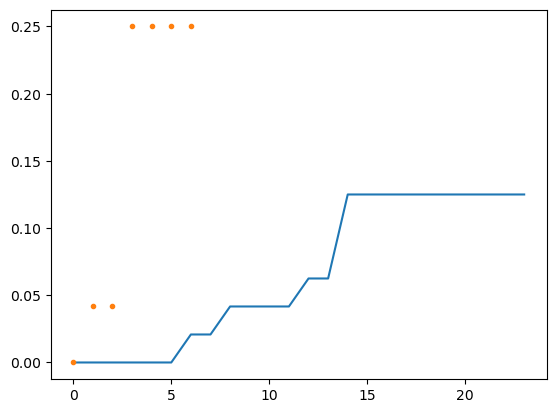

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2a171ff70>

In [537]:
using PyPlot
plot(sort(abs.(vec(solution))))
plot(sort(abs.(vec(u))), ".")

In [538]:
function stiffness_matrix_N0(elems, B_K_det, signs, dofs)
    dim    = size(elems,2) - 1      # the dimension of the problem
    nelems = size(elems,1)          # number of elements
    nedges = maximum(elems)         # number of edges
    ip, w, nip = intquad()          # integration points and weighs (order 2, dimension 2)
    B_K_invabsdet = [inv(abs(x)) for x in B_K_det]
    
    # reference basis function div values on integration points,
    # and number of basis functions
    _, rot, nbasis = basis_N0(ip)
    
    # calculate all local stiffness matrices simultaneously
    Se = zeros(nbasis,nbasis,nelems)
    for i=1:nip
        for m=1:nbasis
            for k=1:nbasis
                for l=1:nelems
                    Se[m,k,l] += w[i] * B_K_invabsdet[l] *
                                 signs[l,m] * rot[i,1,m] *
                                 signs[l,k] * rot[i,1,k]
                end
            end
        end
    end
    return Se
end
function mass_matrix_N0(elems, B_K, B_K_det, signs, dofs)
    dim    = size(elems,2) - 1;   # the dimension of the problem
    nelems = size(elems,1);       # number of elements
    nedges = maximum(elems)       # number of edges
    ip, w, nip = intquad()        # integration points and weighs (order 2, dimension 2)
    B_K_invabsdet = [inv(abs(x)) for x in B_K_det]

    # reference basis function curl values on integration points,
    # and number of basis functions
    val, _, nbasis = basis_N0(ip)

    # calculate all local mass matrices simultaneously
    Me = zeros(nbasis, nbasis, nelems);

    for i=1:nip
        for m=1:nbasis
            for k=1:nbasis
                for l=1:nelems
                    Me[m,k,l] += w[i] * B_K_invabsdet[l] *
                                 dot(signs[l,m] * B_K[:,:,l] * val[i,:,m],
                                     signs[l,k] * B_K[:,:,l] * val[i,:,k])
                end
            end
        end
    end
    return Me
end
function SandT(x1, y1, x2, y2, x3, y3)
    localedges = [2 3; 1 2; 3 1]#[1 2; 1 3; 2 3]
    area = .5abs(det([1. x1 y1
                      1. x2 y2
                      1. x3 y3]))
    temp = inv([x1 x2 x3
                y1 y2 y3
                1. 1. 1.])
    b = temp[:,1]
    c = temp[:,2]
    a = temp[:,3]
    ∇λ = [[b[1], c[1]],
          [b[2], c[2]],
          [b[3], c[3]]]
    φ = zeros(3, 3) # φij = ∇λi ⋅ ∇λj = (bi⋅ci + bj⋅cj)
    v = zeros(3, 3) # vij = ∇λi × ∇λj = (bi⋅cj - bj⋅ci)ẑ
    for ii = 1:3
       for jj = 1:3
           φ[ii, jj] = b[ii] * b[jj] + c[ii] * c[jj]
           v[ii, jj] = b[ii] * c[jj] - b[jj] * c[ii]
       end 
    end

    M = [2. 1. 1.
         1. 2. 1.
         1. 1. 2.] / 12.0

    # Compute S and T
    S = zeros(3, 3)
    T = zeros(3, 3)
    for ii = 1:3
       for jj = 1:3
         i1 = localedges[ii,1]
         i2 = localedges[ii,2]
         j1 = localedges[jj,1]
         j2 = localedges[jj,2]
         S[ii,jj] = 4area*v[i1, i2] * v[j1, j2]
         T[ii,jj] = area*(φ[i2, j2] * M[i1, j1] +
                        - φ[i2, j1] * M[i1, j2] +
                        - φ[i1, j2] * M[i2, j1] +
                        + φ[i1, j1] * M[i2, j2])
       end 
    end
    
    return S, T
end

SandT (generic function with 1 method)

In [539]:
let
    #signs = [+1.0 +1.0 +1.0; +1.0 -1.0 +1.0]
    Se = sparse(stiffness_matrix_N0(elems2edges, B_K_det, signs, nothing)[:,:,1])
    droptol!(Se, 1e-15)
end

3×3 SparseMatrixCSC{Float64, Int64} with 9 stored entries:
  2.0  -2.0  -2.0
 -2.0   2.0   2.0
 -2.0   2.0   2.0

In [540]:
let
  trinodes = elems2nodes[2, :]
  Se, Te = SandT(nodes2coord[trinodes[1],1], nodes2coord[trinodes[1],2],
                 nodes2coord[trinodes[2],1], nodes2coord[trinodes[2],2],
                 nodes2coord[trinodes[3],1], nodes2coord[trinodes[3],2])
  Se
end

3×3 Matrix{Float64}:
 2.0  2.0  2.0
 2.0  2.0  2.0
 2.0  2.0  2.0

In [541]:
function show_mesh(nodes, elems)
    triplot(nodes[:,1], nodes[:,2], triangles=(elems .- 1), "-k")
    return nothing
end

function show_scalar_fieldP0(nodes, elems, u)
    n = size(nodes,1)
    m = size(elems,1)
    nodes = nodes[elems[:],:]
    elems = reshape(1:3m,m,3)
    field = repeat(u, 3)
    fig = figure()
    ax = fig.add_subplot(projection="3d")
    ax.plot_trisurf(nodes[:,1], nodes[:,2], field, triangles=(elems .- 1),
        cmap="inferno", edgecolor="k", antialiased=true)
    ax.view_init(65, 35)
    return nothing
end

function show_vector_fieldRT0(nodes, edges, u)
    n = size(nodes,1)
    m = size(edges,1)
    midpoints = (nodes[edges[:,1],:] .+ nodes[edges[:,2],:]) ./ 2.0
    vectors   = (nodes[edges[:,1],:] .- nodes[edges[:,2],:])
    normals   = [vectors[:,2] -vectors[:,1]]
    scatter(midpoints[:,1], midpoints[:,2])
    #quiver(midpoints[:,1], midpoints[:,2], normals[:,1] .* u, normals[:,2] .* u,
    #    pivot="middle")
end

show_vector_fieldRT0 (generic function with 1 method)

In [542]:
edges2nodes

5×2 Matrix{Int64}:
 1  4
 4  2
 2  1
 1  4
 4  3

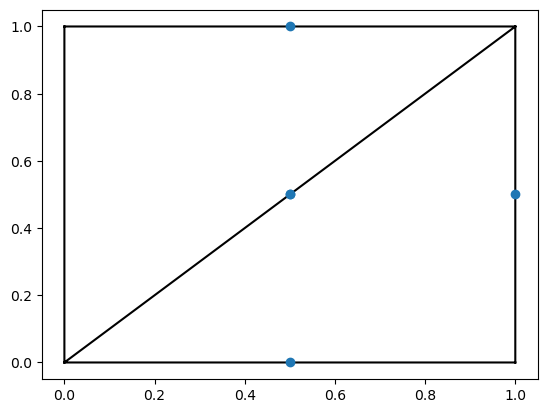

PyObject <matplotlib.collections.PathCollection object at 0x29fb82b50>

In [543]:
show_mesh(nodes2coord, elems2nodes)
show_vector_fieldRT0(nodes2coord, edges2nodes, view(u, 1:nedges))

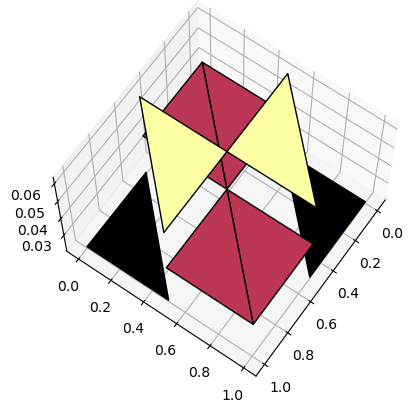

In [505]:
show_scalar_fieldP0(nodes2coord, elems2nodes, view(u, nedges+1:nedges+nelems))

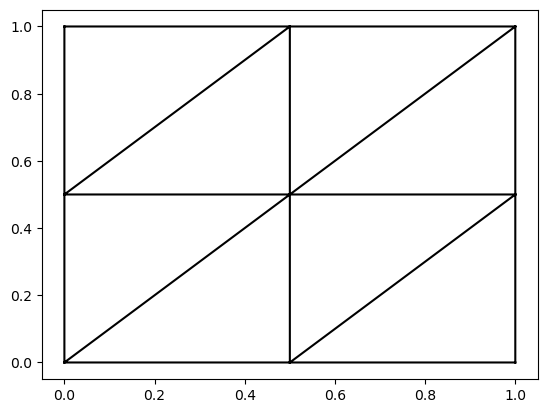

In [506]:
show_mesh(nodes2coord, elems2nodes)